In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2024-05-19 12:37:54--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  --.-KB/s    in 0.1s    

2024-05-19 12:37:54 (178 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [5]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [6]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


<Axes: xlabel='user', ylabel='rating_log10'>

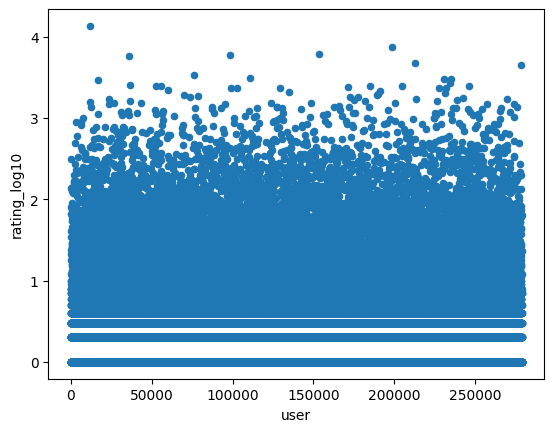

In [8]:
df = df_ratings[["user", "rating"]].groupby(["user"]).count().reset_index()
df['rating_log10'] = np.log10(df['rating'])
df.plot.scatter(x="user", y="rating_log10")

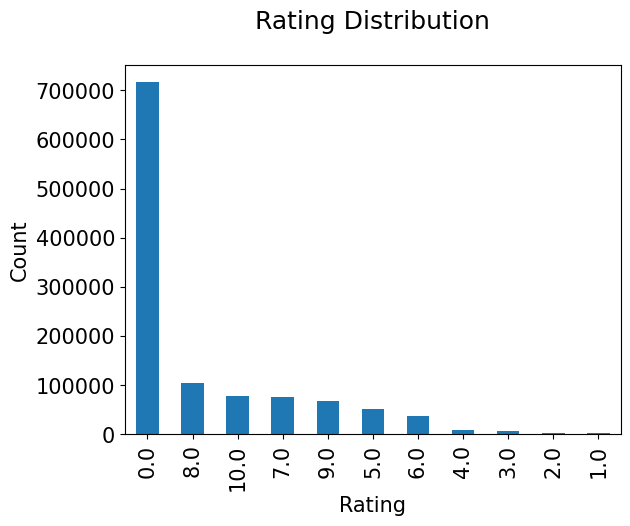

In [13]:
plt.rc("font", size=15)
df_ratings['rating'].value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
counts1 = df_ratings['user'].value_counts()
df_ratings = df_ratings[df_ratings['user'].isin(counts1[counts1 >= 200].index)]
counts = df_ratings['rating'].value_counts()
df_ratings = df_ratings[df_ratings['rating'].isin(counts[counts >= 100].index)]

In [20]:
combine_book_rating = pd.merge(df_ratings, df_books, on='isbn')
print(combine_book_rating.head())

     user        isbn  rating  \
0  277427  002542730X    10.0   
1    3363  002542730X     0.0   
2   11676  002542730X     6.0   
3   12538  002542730X    10.0   
4   13552  002542730X     0.0   

                                               title             author  
0  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner  
1  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner  
2  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner  
3  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner  
4  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner  


In [22]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['title'])

book_ratingCount = (combine_book_rating.
                    groupby(by = ['title'])['rating'].
                    count().
                    reset_index().
                    rename(columns = {'bookRating': 'totalRatingCount'})
                    [['title', 'rating']]
                   )
print(book_ratingCount.head())

                                               title  rating
0   A Light in the Storm: The Civil War Diary of ...       2
1                              Always Have Popsicles       1
2               Apple Magic (The Collector's series)       1
3   Beyond IBM: Leadership Marketing and Finance ...       1
4   Clifford Visita El Hospital (Clifford El Gran...       1


In [24]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
print(rating_with_totalRatingCount.head())

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['rating'].describe())

     user        isbn  rating_x  \
0  277427  002542730X    10.000   
1    3363  002542730X     0.000   
2   11676  002542730X     6.000   
3   12538  002542730X    10.000   
4   13552  002542730X     0.000   

                                               title             author  \
0  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
1  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
2  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
3  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
4  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   

   rating_y  
0        82  
1        82  
2        82  
3        82  
4        82  
count   160587.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: rating, dtype: float64


In [27]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('rating_y >= @popularity_threshold')
print(rating_popular_book.head())

     user        isbn  rating_x  \
0  277427  002542730X    10.000   
1    3363  002542730X     0.000   
2   11676  002542730X     6.000   
3   12538  002542730X    10.000   
4   13552  002542730X     0.000   

                                               title             author  \
0  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
1  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
2  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
3  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   
4  Politically Correct Bedtime Stories: Modern Ta...  James Finn Garner   

   rating_y  
0        82  
1        82  
2        82  
3        82  
4        82  


In [31]:
from scipy.sparse import csr_matrix
rating_popular_book = rating_popular_book.drop_duplicates(['user', 'title'])
rating_popular_book_pivot = rating_popular_book.pivot(index = 'title', columns = 'user', values = 'rating_x').fillna(0)
rating_popular_bookmatrix = csr_matrix(rating_popular_book_pivot.values)

In [33]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(rating_popular_bookmatrix)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine')


In [79]:
query_index = np.random.choice(rating_popular_book_pivot.shape[0])
print(query_index)
print(rating_popular_book_pivot.iloc[query_index,:].values.reshape(1,-1))
distances, indices = model.kneighbors(rating_popular_book_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 12)
rating_popular_book_pivot.index[query_index]

360
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0. 

'Nerd in Shining Armor'

In [80]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_popular_book_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_popular_book_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Nerd in Shining Armor:

1: Key of Valor (Roberts, Nora. Key Trilogy, 3.), with distance of 0.6911564469337463:
2: Purity in Death, with distance of 0.6925538182258606:
3: Full Tilt (Janet Evanovich's Full Series), with distance of 0.6961899399757385:
4: Forever... : A Novel of Good and Evil, Love and Hope, with distance of 0.7061409950256348:
5: The Bachelor (Warner Books Contemporary Romance), with distance of 0.7115671634674072:
6: Beach House, with distance of 0.7117007970809937:
7: Mercy, with distance of 0.71754390001297:
8: Full House (Janet Evanovich's Full Series), with distance of 0.7413413524627686:
9: Key of Light (Key Trilogy (Paperback)), with distance of 0.745112419128418:
10: Killjoy, with distance of 0.7616755366325378:
11: Fast Women, with distance of 0.7722516059875488:


In [81]:
# function to return recommended books - this will be tested
def get_recommends(book):
    query_index = rating_popular_book_pivot.index.get_loc(book)

    # Use the model to find the nearest neighbors
    distances, indices = model.kneighbors(rating_popular_book_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

    # Lists to store recommended books and their distances
    recommended_books = []
    recommended_books_dist = []
    recommends = []

    for i in range(0, len(distances.flatten())-1):
        if i == 0:
            recommends.append(book)
            print('Recommendations for {0}:\n'.format(rating_popular_book_pivot.index[query_index]))
        else:
            recommended_books.append(rating_popular_book_pivot.index[indices.flatten()[i]])
            recommended_books_dist.append(distances.flatten()[i])

    return [recommended_books, recommended_books_dist]

recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(recommends)

Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):

[['Blue Diary', 'The Lovely Bones: A Novel', 'I Know This Much Is True', 'Icy Sparks'], [0.71828747, 0.7234864, 0.7518421, 0.7731839]]


In [89]:
b2 = "Where the Heart Is (Oprah's Book Club (Paperback))"
b1 = 'Unspeakable'
books = get_recommends(b2)
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends(b2)
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.77, 0.77, 0.77, 0.77]
  for i in range(2):
    if abs(recommends[1][i] - recommended_books_dist[i]).round(2) > 0.05:
      print(abs(recommends[1][i] - recommended_books_dist[i]).round(2))
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):

[['Blue Diary', 'The Lovely Bones: A Novel', 'I Know This Much Is True', 'Icy Sparks'], [0.71828747, 0.7234864, 0.7518421, 0.7731839]]
Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):

You passed the challenge! 🎉🎉🎉🎉🎉
